CT Training and Reconstructions with UNet
=========================================

This example demonstrates the training and application of UNet to denoise
previously filtered back projections (FBP) for CT reconstruction inspired
by <cite data-cite="jin-2017-unet"/>.

In [1]:
# isort: off
import os
from time import time

import logging
import ray

ray.init(logging_level=logging.ERROR)  # need to call init before jax import: ray-project/ray#44087

# Set an arbitrary processor count (only applies if GPU is not available).
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import jax

try:
    from jax.extend.backend import get_backend  # introduced in jax 0.4.33
except ImportError:
    from jax.lib.xla_bridge import get_backend

import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scico import flax as sflax
from scico import metric, plot
from scico.flax.examples import load_ct_data
plot.config_notebook_plotting()


platform = get_backend().platform
print("Platform: ", platform)

Platform:  gpu


Read data from cache or generate if not available.

In [2]:
N = 256  # phantom size
train_nimg = 498  # number of training images
test_nimg = 32  # number of testing images
nimg = train_nimg + test_nimg
n_projection = 45  # CT views

trdt, ttdt = load_ct_data(train_nimg, test_nimg, N, n_projection, verbose=True)

Data read from path: ~/.cache/scico/examples/data
Set --training-- size: 498
Set --testing -- size: 32
Data range --images  --  Min:  0.00  Max:  1.00
Data range --sinogram--  Min:  0.00  Max:  0.95
Data range --FBP     --  Min:  0.00  Max:  1.00


Build training and testing structures. Inputs are the filter
back-projected sinograms and outpus are the original generated foams.
Keep training and testing partitions.

In [3]:
train_ds = {"image": trdt["fbp"], "label": trdt["img"]}
test_ds = {"image": ttdt["fbp"], "label": ttdt["img"]}

Define configuration dictionary for model and training loop.

Parameters have been selected for demonstration purposes and relatively
short training. The model depth controls the levels of pooling in the
U-Net model. The block depth controls the number of layers at each level
of depth. The number of filters controls the number of filters at the
input and output levels and doubles (halves) at each pooling (unpooling)
operation. Better performance may be obtained by increasing depth, block
depth, number of filters or training epochs, but may require longer
training times.

In [4]:
# model configuration
model_conf = {
    "depth": 2,
    "num_filters": 64,
    "block_depth": 2,
}
# training configuration
train_conf: sflax.ConfigDict = {
    "seed": 0,
    "opt_type": "SGD",
    "momentum": 0.9,
    "batch_size": 16,
    "num_epochs": 200,
    "base_learning_rate": 1e-2,
    "warmup_epochs": 0,
    "log_every_steps": 1000,
    "log": True,
    "checkpointing": True,
}

Construct UNet model.

In [5]:
channels = train_ds["image"].shape[-1]
model = sflax.UNet(
    depth=model_conf["depth"],
    channels=channels,
    num_filters=model_conf["num_filters"],
    block_depth=model_conf["block_depth"],
)

Run training loop.

In [6]:
workdir = os.path.join(os.path.expanduser("~"), ".cache", "scico", "examples", "unet_ct_out")
train_conf["workdir"] = workdir
print(f"\nJAX process: {jax.process_index()}{' / '}{jax.process_count()}")
print(f"JAX local devices: {jax.local_devices()}\n")

trainer = sflax.BasicFlaxTrainer(
    train_conf,
    model,
    train_ds,
    test_ds,
)
modvar, stats_object = trainer.train()


JAX process: 0 / 1
JAX local devices: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3), CudaDevice(id=4), CudaDevice(id=5), CudaDevice(id=6), CudaDevice(id=7)]



channels: 1   training signals: 498   testing signals: 32   signal size: 256



Network Structure:
+----------------------------------------------------+------------------+---------+-----------+--------+
| Name                                               | Shape            | Size    | Mean      | Std    |
+----------------------------------------------------+------------------+---------+-----------+--------+
| ConvBNMultiBlock_0/ConvBNBlock_0/BatchNorm_0/bias  | (64,)            | 64      | 0.0       | 0.0    |
| ConvBNMultiBlock_0/ConvBNBlock_0/BatchNorm_0/scale | (64,)            | 64      | 1.0       | 0.0    |
| ConvBNMultiBlock_0/ConvBNBlock_0/Conv_0/kernel     | (3, 3, 1, 64)    | 576     | 0.00194   | 0.488  |
| ConvBNMultiBlock_0/ConvBNBlock_1/BatchNorm_0/bias  | (64,)            | 64      | 0.0       | 0.0    |
| ConvBNMultiBlock_0/ConvBNBlock_1/BatchNorm_0/scale | (64,)            | 64      | 1.0       | 0.0    |
| ConvBNMultiBlock_0/ConvBNBlock_1/Conv_0/kernel     | (3, 3, 64, 64)   | 36,864  | -0.00022  | 0.0588 |
| ConvBNMultiBlock_1/ConvBNBlock_0/B

Initial compilation, which might take some time ...


Initial compilation completed.



Epoch  Time      Train_LR  Train_Loss  Train_SNR  Eval_Loss  Eval_SNR
---------------------------------------------------------------------
   32  4.60e+01  0.010000    0.010790       7.70   0.006069      8.78


   64  8.46e+01  0.010000    0.005745       9.02   0.005510      9.20


   96  1.22e+02  0.010000    0.005406       9.28   0.005278      9.39


  129  1.60e+02  0.010000    0.005220       9.44   0.005121      9.52


  161  1.98e+02  0.010000    0.005097       9.54   0.005017      9.61


  193  2.36e+02  0.010000    0.005006       9.62   0.004937      9.68


Evaluate on testing data.

In [7]:
del train_ds["image"]
del train_ds["label"]

fmap = sflax.FlaxMap(model, modvar)
del model, modvar

maxn = test_nimg // 2
start_time = time()
output = fmap(test_ds["image"][:maxn])
time_eval = time() - start_time
output = jax.numpy.clip(output, a_min=0, a_max=1.0)

Evaluate trained model in terms of reconstruction time and data fidelity.

In [8]:
snr_eval = metric.snr(test_ds["label"][:maxn], output)
psnr_eval = metric.psnr(test_ds["label"][:maxn], output)
print(
    f"{'UNet training':15s}{'epochs:':2s}{train_conf['num_epochs']:>5d}"
    f"{'':21s}{'time[s]:':10s}{trainer.train_time:>7.2f}"
)
print(
    f"{'UNet testing':15s}{'SNR:':5s}{snr_eval:>5.2f}{' dB'}{'':3s}"
    f"{'PSNR:':6s}{psnr_eval:>5.2f}{' dB'}{'':3s}{'time[s]:':10s}{time_eval:>7.2f}"
)

UNet training  epochs:  200                     time[s]:   243.56
UNet testing   SNR:  9.71 dB   PSNR: 20.13 dB   time[s]:     6.62


Plot comparison.

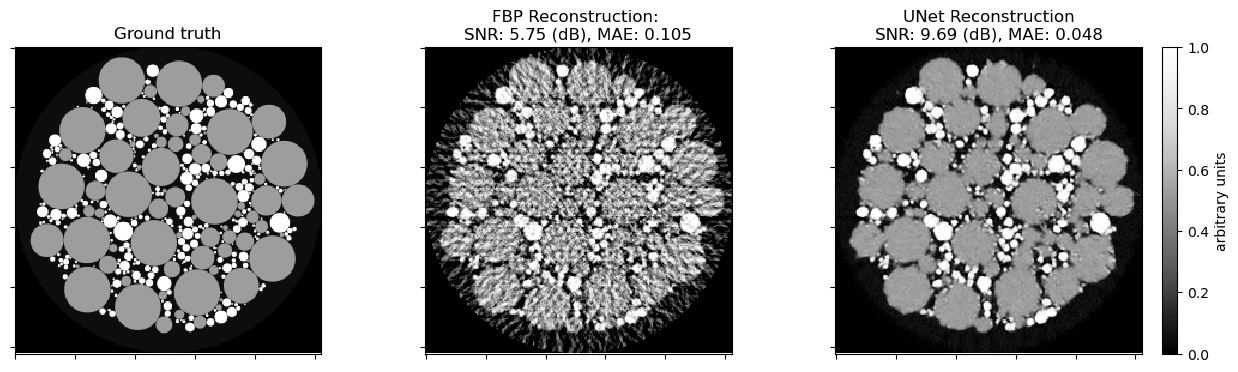

In [9]:
key = jax.random.PRNGKey(123)
indx = jax.random.randint(key, shape=(1,), minval=0, maxval=test_nimg)[0]

fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(test_ds["label"][indx, ..., 0], title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    test_ds["image"][indx, ..., 0],
    title="FBP Reconstruction: \nSNR: %.2f (dB), MAE: %.3f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], test_ds["image"][indx, ..., 0]),
        metric.mae(test_ds["label"][indx, ..., 0], test_ds["image"][indx, ..., 0]),
    ),
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    output[indx, ..., 0],
    title="UNet Reconstruction\nSNR: %.2f (dB), MAE: %.3f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
        metric.mae(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
    ),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics. Statistics are generated only if a training
cycle was done (i.e. if not reading final epoch results from checkpoint).

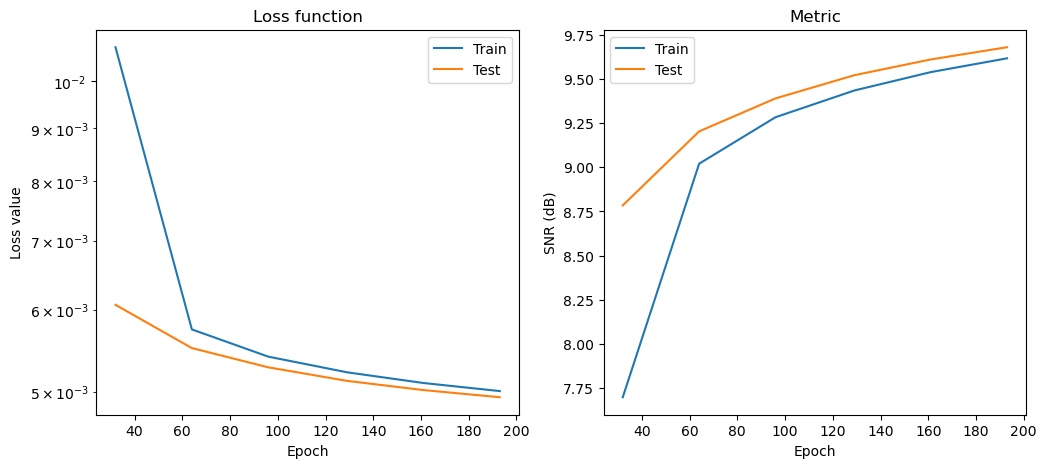

In [10]:
if stats_object is not None and len(stats_object.iterations) > 0:
    hist = stats_object.history(transpose=True)
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot.plot(
        np.vstack((hist.Train_Loss, hist.Eval_Loss)).T,
        x=hist.Epoch,
        ptyp="semilogy",
        title="Loss function",
        xlbl="Epoch",
        ylbl="Loss value",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[0],
    )
    plot.plot(
        np.vstack((hist.Train_SNR, hist.Eval_SNR)).T,
        x=hist.Epoch,
        title="Metric",
        xlbl="Epoch",
        ylbl="SNR (dB)",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[1],
    )
    fig.show()